In [207]:
import requests
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve
from numpy.polynomial.polynomial import polyfit
from matplotlib.ticker import FuncFormatter

# Data Collection

### Collecting Players

To collect a large sample of players' stats, we must make API requests by players' unique identifiers.  In order to collect players' IDs, we elected to collect players from our recent games (specifically, Jon's 200 most recent games).

While this is not a truly random sample from the player population, we felt it would be representative of the population, as matchmaking in the quickplay game mode is dependent only on connection, with no element of skill taken into account.  Therefore, our sample is a random sample of players with a reasonable connection to the Western United States, which is likely representative of a full random sample.  Unfortunately, it did not seem feasible to collect a random sample from the entire player population, given what information was available to us.

Our unfiltered collection of features is the set of quickplay stats available through the Bungie API through the `GetHistoricalStats` endpoint.  These stats include both quantity stats and efficiency stats (per-game averages, as denoted by the suffix `_pga`.

In [127]:
MID_ME = 'redacted' # player ID
API_KEY = 'redacted' # API key
HEADERS = {"X-API-Key":API_KEY} # request header dict

In [117]:
r = requests.get("https://www.bungie.net/platform/Destiny2/4/Profile/{}/?components=200".format(MID_ME), headers=HEADERS);

#convert the json object we received into a Python dictionary object
profile = r.json()

#classType: titan=0, hunter=1, warlock=2
#genderType: male=0, female=1
#raceType: human=0, awoken=1, exo=2

In [118]:
for c in profile['Response']['characters']['data']:
    c_attrs = profile['Response']['characters']['data'][c]
    if c_attrs['raceType'] == 1 and c_attrs['classType'] == 0 and c_attrs['genderType'] == 1:
        my_titan = c_attrs

In [121]:
GAMES_COUNT = 200
PVP_QUICKPLAY_MODE = 70

r = requests.get("https://www.bungie.net/Platform/Destiny2/4/Account/{}/Character/{}/Stats/Activities/?count={}&mode={}".format(
    my_titan['membershipId'], my_titan['characterId'], GAMES_COUNT, PVP_QUICKPLAY_MODE), headers=HEADERS);

In [123]:
my_game_history = r.json()['Response']['activities']
game_instance_ids = [game['activityDetails']['instanceId'] for game in my_game_history]
players = set()

for inst_id in game_instance_ids:
    r = requests.get("https://www.bungie.net/platform/Destiny2/Stats/PostGameCarnageReport/{}/".format(inst_id), headers=HEADERS);

    game = r.json()
    #print(game)

    for player in game['Response']['entries']:
        player_mem_id = player['player']['destinyUserInfo']['membershipId']
        player_char_id = player['characterId']
        players.add((player_mem_id, player_char_id))
print('total unfiltered players: {}'.format(len(players)))

total unfiltered players: 1601


In [125]:
players_dict = dict(players)
r = requests.get("https://www.bungie.net/Platform/Destiny2/4/Account/{}/Character/{}/Stats/?groups=0&modes={}&periodType=0".format(my_titan['membershipId'], my_titan['characterId'], PVP_QUICKPLAY_MODE), headers=HEADERS)
stats = r.json()
features = ['glory', 'characterId']
for statname in stats['Response']['pvpQuickplay']['allTime']:
    features.append(statname)
    if 'pga' in stats['Response']['pvpQuickplay']['allTime'][statname]:
        features.append(statname+'_pga')
print(features)
player_df = pd.DataFrame(index=players_dict.keys(), columns=features, dtype=float)

['glory', 'characterId', 'activitiesEntered', 'activitiesWon', 'assists', 'assists_pga', 'totalDeathDistance', 'averageDeathDistance', 'totalKillDistance', 'kills', 'kills_pga', 'averageKillDistance', 'secondsPlayed', 'secondsPlayed_pga', 'deaths', 'deaths_pga', 'averageLifespan', 'score', 'score_pga', 'averageScorePerKill', 'averageScorePerLife', 'bestSingleGameKills', 'bestSingleGameScore', 'opponentsDefeated', 'efficiency', 'killsDeathsRatio', 'killsDeathsAssists', 'objectivesCompleted', 'objectivesCompleted_pga', 'precisionKills', 'precisionKills_pga', 'resurrectionsPerformed', 'resurrectionsPerformed_pga', 'resurrectionsReceived', 'resurrectionsReceived_pga', 'suicides', 'suicides_pga', 'weaponKillsAutoRifle', 'weaponKillsAutoRifle_pga', 'weaponKillsBeamRifle', 'weaponKillsBeamRifle_pga', 'weaponKillsBow', 'weaponKillsBow_pga', 'weaponKillsFusionRifle', 'weaponKillsFusionRifle_pga', 'weaponKillsHandCannon', 'weaponKillsHandCannon_pga', 'weaponKillsTraceRifle', 'weaponKillsTraceRif

### Querying Stats

For each player in our collection of player IDs, we query the player's Glory (competitive rank) as a character progression, and query their stats if they have a non-zero Glory rank.  If their progression data was unavailable (indicative of a private profile) or they had a glory of 0 (indicative of not having a competitive rank), we removed the player from our sample.

We then dropped specific stats that were not applicable to our sample.  These stats had a value of 0 for every player, as they aren't applicable to quickplay game modes.

In [126]:
# this cell sends several API calls per player and takes a long time to run
GLORY_PROGRESSION_HASH = '2679551909'
for memId, chId in players_dict.items():
    stats = {}
    r = requests.get("https://www.bungie.net/platform/Destiny2/4/Profile/{}/?components=202".format(memId), headers=HEADERS);
    if 'data' in r.json()['Response']['characterProgressions'] and chId in r.json()['Response']['characterProgressions']['data']:
        glory = r.json()['Response']['characterProgressions']['data'][chId]['progressions'][GLORY_PROGRESSION_HASH]['currentProgress']
        if glory == 0:
            continue
        stats['glory'] = glory
    else:
        continue
        
    r2 = requests.get("https://www.bungie.net/Platform/Destiny2/4/Account/{}/Character/{}/Stats/?groups=0&modes={}&periodType=0".format(memId, chId, PVP_QUICKPLAY_MODE), headers=HEADERS)
    raw_stats = r2.json()['Response']['pvpQuickplay']['allTime']
    for statname in raw_stats:
        stats[statname] = raw_stats[statname]['basic']['value'] 
        if 'pga' in raw_stats[statname]:
            stats[statname+'_pga'] = raw_stats[statname]['pga']['value'] 
    stats['characterId'] = chId
    player_df.loc[memId] = stats

In [128]:
stats_to_drop = ['characterId',
                 'totalDeathDistance',
                 'averageDeathDistance',
                 'resurrectionsPerformed',
                 'resurrectionsReceived',
                 'weaponKillsRelic']
player_df_clean = player_df.dropna().drop(stats_to_drop+[s+'_pga' for s in stats_to_drop], axis=1, errors='ignore')
player_df_clean = player_df_clean.iloc[1:]
print(len(player_df_clean))

1180


In [129]:
player_df_clean.head(5)

,glory,activitiesEntered,activitiesWon,assists,assists_pga,totalKillDistance,kills,kills_pga,averageKillDistance,secondsPlayed,...,teamScore,teamScore_pga,totalActivityDurationSeconds,totalActivityDurationSeconds_pga,combatRating,fastestCompletionMs,longestKillDistance,highestCharacterLevel,highestLightLevel,fireTeamActivities
4611686018483785047,256,27,10,111,4.11111,3658,215,7.96296,17.014,13555,...,2520,93.3333,15458,572.519,109.835,338300,59,44,446,10
4611686018475169591,2644,307,122,1302,4.24104,75077,4269,13.9055,17.5866,163190,...,29534,96.202,189611,617.625,144.487,597600,99,50,700,134
4611686018484173680,2200,234,85,1207,5.15812,39536,2960,12.6496,13.3568,137636,...,21982,93.9402,142577,609.303,140.826,500300,88,50,700,106
4611686018468752759,4252,597,476,3273,5.48241,179053,12375,20.7286,14.4689,323245,...,62229,104.236,332732,557.34,218.249,58500,112,50,700,497
4611686018470743629,1154,177,102,772,4.36158,23352,1574,8.89266,14.8361,97676,...,14530,82.0904,99667,563.09,116.319,243200,90,50,693,86


# EDA

We plotted a collection of stats that we believed may be somewhat associated with Glory.  These stats included:

1. Kill-Death Ratio
1. Average Score Per Life
1. Total Career Kills
1. Total Orbs Created<sup>1</sup> 
1. Efficiency<sup>2</sup> 
1. Win-Loss Ratio
1. Score Per Game
1. Precision Kills
1. Combat Rating<sup>3</sup> 

The above stats correspond to figures 1 through 9, respectively.

We found that the stats we chose did seem moderately associated with Glory, to differing degrees.

<sup>1</sup> Orbs are a feature unique to Destiny 2, generated on multikills with specific weapons or super abilities.  Collecting orbs generated by teammates provides super ability charge, and is an important facet of higher level strategy.

<sup>2</sup> Efficiency is tracked by the game as `(kills + assists) / deaths`.

<sup>3</sup> Combat Rating is an internal hidden value only available through the API, which is a skill rating based on a TrueSkill system similar to Elo.

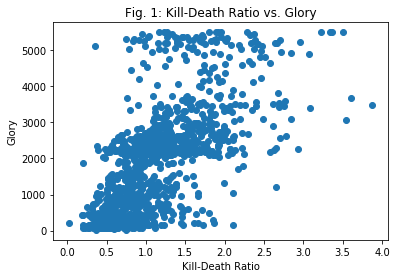

In [179]:
kd_df = player_df_clean[["glory", "killsDeathsRatio"]]
x = np.array(kd_df["killsDeathsRatio"].tolist())
y = np.array(kd_df["glory"].tolist())
b, m = polyfit(x, y, 1)

plt.scatter(kd_df["killsDeathsRatio"], kd_df["glory"])
plt.xlabel('Kill-Death Ratio')
plt.ylabel('Glory')
plt.title('Fig. 1: Kill-Death Ratio vs. Glory')
#plt.plot(x, b + m * x, '-')
plt.show()


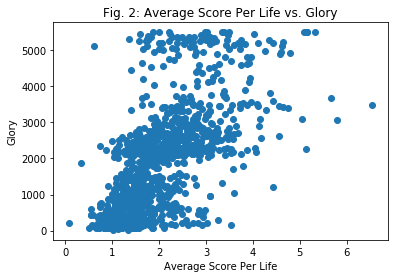

In [132]:
spl_df = player_df_clean[["glory", "averageScorePerLife"]]
plt.scatter(spl_df["averageScorePerLife"], spl_df["glory"])
plt.xlabel('Average Score Per Life')
plt.ylabel('Glory')
plt.title('Fig. 2: Average Score Per Life vs. Glory')
plt.show()

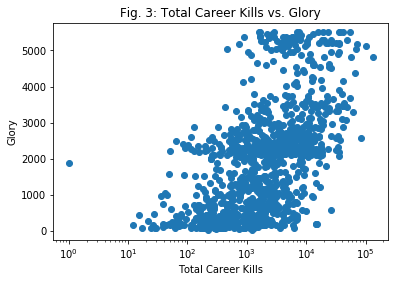

In [181]:
kill_df = player_df_clean[["glory", "kills"]]
x = np.array(kill_df["kills"].tolist())
y = np.array(kill_df["glory"].tolist())
b, m = polyfit(x, y, 1)

plt.scatter(kill_df["kills"], kill_df["glory"])
plt.xscale('log')
plt.xlabel('Total Career Kills')
plt.ylabel('Glory')
plt.title('Fig. 3: Total Career Kills vs. Glory')
plt.show()

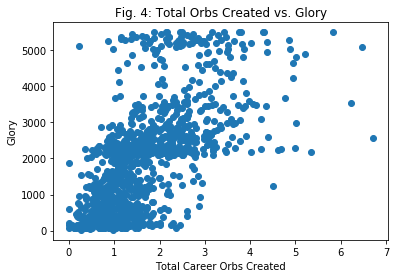

In [134]:
orbpga_df = player_df_clean[["glory", "orbsDropped_pga"]]
plt.scatter(orbpga_df["orbsDropped_pga"], orbpga_df["glory"])
plt.xlabel('Total Career Orbs Created')
plt.ylabel('Glory')
plt.title('Fig. 4: Total Orbs Created vs. Glory')
plt.show()

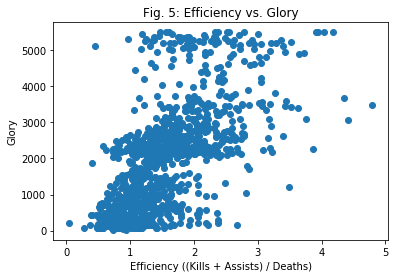

In [135]:
eff_df = player_df_clean[["glory", "efficiency"]]
plt.scatter(eff_df["efficiency"], eff_df["glory"])
plt.xlabel('Efficiency ((Kills + Assists) / Deaths)')
plt.ylabel('Glory')
plt.title('Fig. 5: Efficiency vs. Glory')
plt.show()

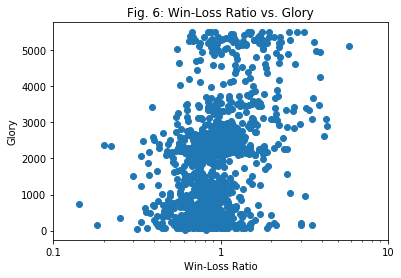

In [136]:
wl_df = player_df_clean[["glory", "winLossRatio"]]
wl_df = wl_df[wl_df["winLossRatio"] > 0]
ax=plt.scatter(wl_df['winLossRatio'], wl_df["glory"])
plt.xscale('log')
plt.xticks([.1, 1, 10], [.1, 1, 10])
plt.xlabel('Win-Loss Ratio')
plt.ylabel('Glory')
plt.title('Fig. 6: Win-Loss Ratio vs. Glory')
plt.show()

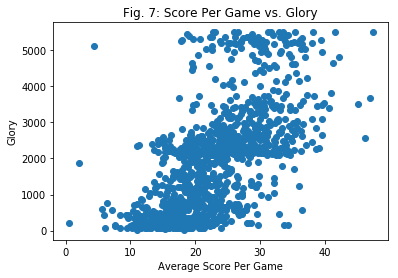

In [137]:
spg_df = player_df_clean[["glory", "score_pga"]]
plt.scatter(spg_df["score_pga"], spg_df["glory"])
plt.xlabel('Average Score Per Game')
plt.ylabel('Glory')
plt.title('Fig. 7: Score Per Game vs. Glory')
plt.show()

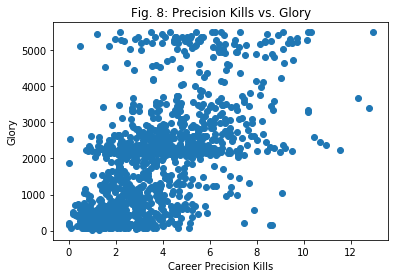

In [138]:
precpg_df = player_df_clean[["precisionKills_pga", "glory"]]
plt.scatter(precpg_df["precisionKills_pga"], precpg_df["glory"])
plt.xlabel('Career Precision Kills')
plt.ylabel('Glory')
plt.title('Fig. 8: Precision Kills vs. Glory')
plt.show()

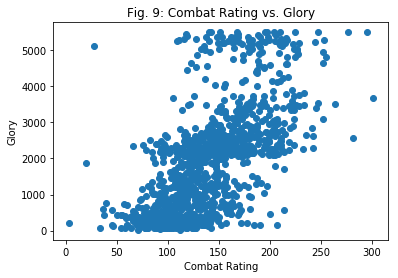

In [139]:
combat_df = player_df_clean[["combatRating", "glory"]]
plt.scatter(combat_df["combatRating"], combat_df["glory"])
plt.xlabel('Combat Rating')
plt.ylabel('Glory')
plt.title('Fig. 9: Combat Rating vs. Glory')
plt.show()

# Model Training and Testing

While we tried many combinations of features (such as small collections of individually chosen features, efficiency-only stats, and quantity-only stats), we found that the best results were generally obtained using all the features available to us, which is what we used in this section.

### Linear Regression

Our first idea was to use linear regression with sklearn to attempt to predict a player's Glory using their quickplay stats.  The results were less than ideal, as our root mean squared error was about 1100, when predicting a value on a scale from 0-5500.  We also calculated our mean absolute error, which was 812.

In [151]:
train, test = sklearn.model_selection.train_test_split(player_df_clean, train_size=0.8, test_size=0.2)
print('Train:', train.shape, 'Test:', test.shape)

Train: (944, 94) Test: (236, 94)


In [140]:
model = LinearRegression()
model.fit(train.drop('glory', axis=1), train['glory'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [141]:
def rmse(errors): # taken from proj3
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

In [182]:
lin_reg_rmse = rmse(test['glory'] - model.predict(test.drop('glory', axis=1)))
lin_reg_rmse

973.288378791845

In [183]:
lin_reg_avg_abs_err = (test['glory'] - model.predict(test.drop('glory', axis=1))).apply(abs).mean()
lin_reg_avg_abs_err

720.1242633617273

### Logistic Regression

We then tried using logistic regression to predict a player's rank bracket.  There are five rank brackets, as follows:

Rank|Glory Range
---|---
Guardian|0-199
Brave|200-1049
Heroic|1050-2099
Fabled|2100-3499
Mythic|3500-5500

We saw moderate success with this approach, with a 49% success rate.

In [144]:
def glory_to_rank(glory):
    if glory < 200:
        return 0
    elif glory < 1050:
        return 1
    elif glory < 2100:
        return 2
    elif glory < 3500:
        return 3
    else:
        return 4

In [145]:
player_df_clean_rank = player_df_clean.copy()
player_df_clean_rank['rank'] = player_df_clean_rank['glory'].apply(glory_to_rank)
player_df_clean_rank = player_df_clean_rank.drop('glory', axis=1)

train2, test2 = sklearn.model_selection.train_test_split(player_df_clean_rank, train_size=0.8, test_size=0.2)
print('Train:', train2.shape, 'Test:', test2.shape)

Train: (944, 94) Test: (236, 94)


In [146]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression()
model2.fit(train2.drop('rank', axis=1), train2['rank'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [184]:
log_reg_acc = model2.score(test2.drop('rank', axis=1), test2['rank'])
log_reg_acc

0.4872881355932203

### Binary Logistic Regression

Our next approach was to reduce the problem to a binary classification - whether a user was below Fabled, or Fabled and above.  We chose this because the only tangible rewards to the Glory system are obtained at Fabled (aside from one exception obtained at 5450 Glory, nearly the maximum rank), so many users reach Fabled and choose to stop playing the competitive mode, as they've obtained all the rewards realistically obtainable to them.  Therefore, this segments the competitive playerbase into two categories - players that have not yet reached Fabled, and those that have.

We saw great results with this approach, with our model being able to predict whether a player in the test set reached Fabled or not over 83% of the time.  Given the issues with the accuracy of the Glory system in reflecting player skill (as mentioned in our write-up), we felt this was a great result.

We additionally plotted a precision-recall curve for the model and test set.

In [175]:
player_df_clean_fabled = player_df_clean_rank.copy()
player_df_clean_fabled['fabled'] = player_df_clean_fabled['rank'].apply(lambda x: abs(x - 1) // 2)
player_df_clean_fabled = player_df_clean_fabled.drop('rank', axis=1)
train3, test3 = sklearn.model_selection.train_test_split(player_df_clean_fabled, train_size=0.8, test_size=0.2)

In [185]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression()
model3.fit(train3.drop('fabled', axis=1), train3['fabled'])
binary_reg_acc = model3.score(test3.drop('fabled', axis=1), test3['fabled'])
binary_reg_acc

0.8347457627118644

Text(0, 0.5, 'Precision')

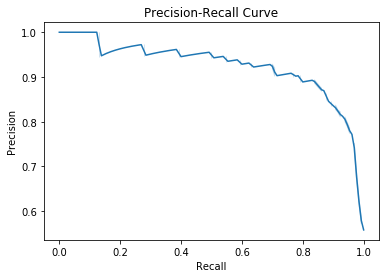

In [195]:
pre, rec, thr = precision_recall_curve(test3['fabled'], model3.predict_proba(test3.drop('fabled', axis=1))[:,1])
df = pd.DataFrame()
df[('pre')], df[('rec')] = pre, rec
ax = sns.lineplot(x='rec', y='pre', data=df)
ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

### Decision Tree Classification

Out of curiosity, we tried to classify players as having reached Fabled or not using a decision tree classifier in sklearn.  While not bad, our result was inferior to that of binary logistic regression.

In [186]:
from sklearn.tree import DecisionTreeClassifier
model4 = DecisionTreeClassifier()
model4.fit(train3.drop('fabled', axis=1), train3['fabled'])
binary_tree_acc = model4.score(test3.drop('fabled', axis=1), test3['fabled'])
binary_tree_acc

0.7627118644067796

Text(0.5, 1.0, 'Accuracy of Models')

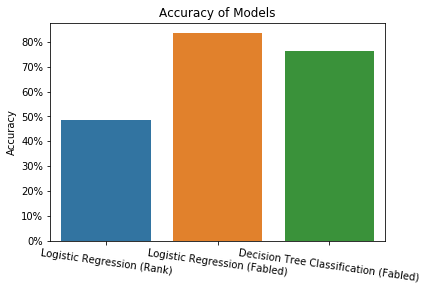

In [208]:
df = pd.DataFrame(index=['Logistic Regression (Rank)', 'Logistic Regression (Fabled)', 'Decision Tree Classification (Fabled)'],
                  columns=['Accuracy'],
                  data=[[log_reg_acc], [binary_reg_acc], [binary_tree_acc]])
ax = sns.barplot(x=df.index, y='Accuracy', data=df)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xticks(rotation=-8)
plt.title('Accuracy of Models')